# CVPR Workshop Figs

## Imports and loading data from wandb

In [34]:
import pandas as pd
import wandb
import src.viz as viz
import geomstats.backend as gs
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.hyperbolic import Hyperbolic
from geomstats.geometry.discrete_surfaces import (
    DiscreteSurfaces,
    ElasticMetric,
    _ExpSolver,
)
import plotly.io as pio
import pyvista as pv

import src.setcwd
import src.datasets.utils as data_utils
import src.datasets.synthetic as synthetic
import project_regression.default_config as default_config

src.setcwd.main()
import os

my_28brains_dir = os.path.dirname(os.getcwd())
print("my28brains_dir: ", my_28brains_dir)

Working directory:  /Users/adelemyers/code/my28brains/src
Directory added to path:  /Users/adelemyers/code/my28brains
Directory added to path:  /Users/adelemyers/code/my28brains/src
Directory added to path:  /Users/adelemyers/code/my28brains/H2_SurfaceMatch
Directory added to path:  /Users/adelemyers/code/my28brains/src/notebooks
Directory added to path:  /Users/adelemyers/code/my28brains/src/notebooks/csv
my28brains_dir:  /Users/adelemyers/code/my28brains


In [35]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("bioshape-lab/my28brains-project_regression")

model_name = "model_2"

if model_name == "model_4":
    start_date = pd.to_datetime("2023-02-21")
    end_date = pd.to_datetime("2024-03-09")
else: 
    start_date = pd.to_datetime("2023-04-03")
    end_date = pd.to_datetime("2024-04-09")

desired_tags = {model_name}

summary_list, config_list, name_list = [], [], []
for run in runs: 
    run_tags = set(run.tags)
    
    if pd.to_datetime(run.createdAt) > start_date and desired_tags.issubset(run_tags):
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)
    
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
              if not k.startswith('_')})
    
        # .name is the human-readable name of the run.
        name_list.append(run.name)

summary_df = pd.DataFrame.from_dict(
    summary_list)
config_df = pd.DataFrame.from_dict(
    config_list)
name_df = pd.DataFrame.from_dict(
    name_list)

runs_df = pd.concat([summary_df, config_df, name_df], axis = 1)

save_path = os.path.join(my_28brains_dir, f"project_regression/notebooks/csv/CVPRW/{model_name}.csv")

runs_df.to_csv(save_path)

# Choose which model to analyze

In [6]:
model_name = "model_4"
dataset_name = "synthetic_mesh"
# dataset_name = "hypersphere"
# dataset_name = "hyperboloid"

path = os.path.join(my_28brains_dir, f"project_regression/notebooks/csv/CVPRW/{model_name}.csv")

df = pd.read_csv(path)
df = df.dropna(axis=1, how='all')


df = df[df["dataset_name"] == dataset_name]

if dataset_name is not "synthetic_mesh":
    df = df[df["space_dimension"] == 2]

df.head()

,Unnamed: 0,X,n_faces,true_coef,noise_factor,true_coef_fig,estimator_duration_time,estimator_intercept_hat,_step,_timestamp,...,estimator.1,tol_factor,project_dir,start_shape,torch_dtype,dataset_name,linear_noise.1,noise_factor.1,project_linear_noise,0
0,0,"[0, 0.03333333333333333, 0.06666666666666667, ...",12,"[[1, -1, -1], [-1, -1, -1], [0, 0, 0], [0, 0, ...",0.6,{'path': 'media/object3D/true_coef_fig_2_f5c1d...,0.002810,"[[1.4542665551040013, 0.1997333028758334, 0.18...",5,1.710140e+09,...,LR,0.01,/home/adele/code/my28brains/project_regression,cube,torch.float64,synthetic_mesh,True,0.6,True,run_48cmxcmu
1,1,"[0, 0.03333333333333333, 0.06666666666666667, ...",12,"[[1, -1, -1], [-1, -1, -1], [0, 0, 0], [0, 0, ...",0.4,{'path': 'media/object3D/true_coef_fig_2_f5c1d...,0.002454,"[[1.231332095367428, 0.7720164054663317, 0.950...",5,1.710140e+09,...,LR,0.01,/home/adele/code/my28brains/project_regression,cube,torch.float64,synthetic_mesh,True,0.4,True,run_4i7mvqe5
2,2,"[0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25,...",12,"[[1, -1, -1], [-1, -1, -1], [0, 0, 0], [0, 0, ...",0.6,{'path': 'media/object3D/true_coef_fig_2_f5c1d...,0.002291,"[[0.06270473053525372, 1.416340421520817, 1.68...",5,1.710140e+09,...,LR,0.01,/home/adele/code/my28brains/project_regression,cube,torch.float64,synthetic_mesh,True,0.6,True,run_d89muqcf
3,3,"[0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25,...",12,"[[1, -1, -1], [-1, -1, -1], [0, 0, 0], [0, 0, ...",0.4,"{'_type': 'object3D-file', 'sha256': 'f5c1de40...",0.002451,"[[0.430076809795, 1.7791838173734462, 1.658355...",5,1.710140e+09,...,LR,0.01,/home/adele/code/my28brains/project_regression,cube,torch.float64,synthetic_mesh,True,0.4,True,run_yk7piil1
4,4,"[0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0...",12,"[[1, -1, -1], [-1, -1, -1], [0, 0, 0], [0, 0, ...",0.6,"{'size': 418, '_type': 'object3D-file', 'sha25...",0.002522,"[[1.2668128732637924, -0.9534748759403876, 2.7...",5,1.710140e+09,...,LR,0.01,/home/adele/code/my28brains/project_regression,cube,torch.float64,synthetic_mesh,True,0.6,True,run_sebycp36


## 1. True geodesics, noisy points, and fits for MESH geodesics

In [7]:
df.columns

Index(['Unnamed: 0', 'X', 'n_faces', 'true_coef', 'noise_factor',
       'true_coef_fig', 'estimator_duration_time', 'estimator_intercept_hat',
       '_step', '_timestamp', 'estimator_coef_err_sum',
       'estimator_intercept_err_norm', 'estimator', 'mesh_diameter',
       'rmsd_geodesic', 'lr_intercept_err', 'linear_intercept_hat',
       'estimator_y_prediction_fig', 'estimator_intercept_hat_fig', '_wandb',
       'n_vertices', 'rmsd_linear', 'estimator_coef_err',
       'estimator_intercept_err', '_runtime', 'linear_noise',
       'lr_coef_err_sum', 'lr_coef_err_norm', 'lr_intercept_err_norm',
       'lr_coef_err', 'geodesic_tol', 'true_intercept', 'linear_coef_hat',
       'lr_intercept_err_sum', 'estimator_coef_hat_fig',
       'estimator_intercept_err_sum', 'model', 'lr_duration_time',
       'estimator_coef_hat', 'mesh_sequence_vertices', 'true_intercept_fig',
       'estimator_coef_err_norm', 'n_gr_iterations',
       'n_gr_jacobian_evaluations', 'n_gr_function_evaluations', 

In [32]:
mesh_faces = gs.array(
        [
            [0, 1, 4],
            [1, 4, 5],
            [0, 3, 4],
            [3, 4, 7],
            [1, 2, 3],
            [0, 1, 3],
            [1, 2, 5],
            [2, 5, 6],
            [5, 6, 7],
            [4, 5, 7],
            [2, 6, 7],
            [2, 3, 7],
        ]
)

space = DiscreteSurfaces(faces=gs.array(mesh_faces))
elastic_metric = ElasticMetric(
    space=space,
    a0=default_config.a0,
    a1=default_config.a1,
    b1=default_config.b1,
    c1=default_config.c1,
    d1=default_config.d1,
    a2=default_config.a2,
)

true_coef = df['true_coef'].values[0]
optimizer = data_utils.get_optimizer(
            False, n_vertices=len(true_coef), max_iter=100, tol=1e-5
)

elastic_metric.exp_solver = _ExpSolver(
    n_steps=3, optimizer=optimizer
)
space.metric = elastic_metric

In [33]:
X = df['X'].values[0]
true_coef = df['true_coef'].values[0]
true_intercept =  df['true_intercept'].values[0]

# (
#     noiseless_mesh_sequence_vertices,
#     mesh_faces,
#     X,
#     true_intercept,
#     true_coef,
# ) = synthetic.generate_parameterized_mesh_geodesic(
#     start_mesh, end_mesh, config, n_X, config.n_steps
# )


noiseless_geodesic_fn = elastic_metric.geodesic(
    initial_point=true_intercept, initial_tangent_vec=true_coef
)
noiseless_geodesic = geodesic_fn(X)

noisy_points = synthetic.add_linear_noise(
        space,
        noiseless_geodesic,
        "synthetic_mesh",
        False,
        noise_factor=0.4,
        random_seed=0,
)

estimator_intercept_hat = df['estimator_intercept_hat'].values[0]
estimator_coef_hat = df['estimator_coef_hat'].values[0]

AttributeError: '_ExpSolver' object has no attribute 'solves_ivp'

In [ ]:
geodesic_viz = viz.offset_mesh_sequence(geodesic)
geodesic_viz = [mesh.numpy() for mesh in geodesic_viz]
viz.plot_mesh_sequence(geodesic_viz, savefig=True, label = "geodesic_noise_0.5")

## 2. 2D sphere showing the difference between: linear gaussian, manifold gaussian, projected gaussian, deformed gaussian noises

(-1.2, 1.2, -1.2, 1.2, -1.2, 1.2)

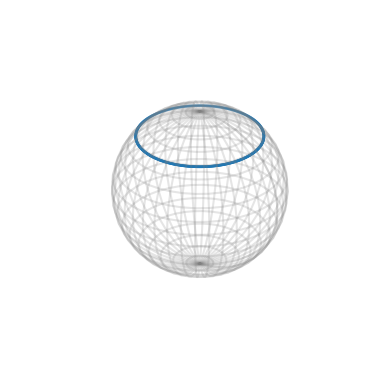

In [11]:
import geomstats.backend as gs

from geomstats.geometry.hypersphere import Hypersphere
from geomstats.geometry.hyperboloid import Hyperboloid

space = Hypersphere(dim=2)

# Riemannian Gaussian noise, aka, Geodesic noise
theta = gs.arange(0, 2*gs.pi, step = 0.01)

radius = 0.8
points_on_circle = [gs.array([radius*gs.cos(t), radius*gs.sin(t), 0.]) for t in theta]
points_on_circle = gs.array(points_on_circle)

points_on_level_set = space.metric.exp(points_on_circle, base_point=gs.array([0., 0., 1.]))

import geomstats.visualization as visualization


ax = visualization.plot(points_on_level_set, space="S2", s=1)
ax.grid(False)
ax.axis("off")

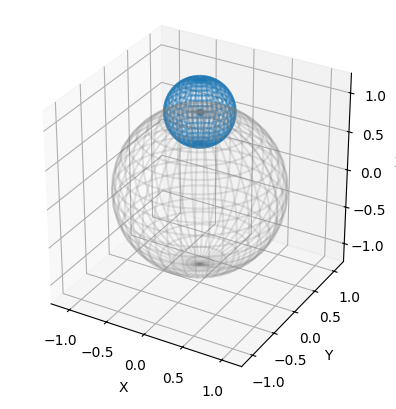

In [13]:
# Unprojected Eucliean Gaussian noise

n_meridians = 40
n_circles_latitude = 20


u, v = gs.meshgrid(
    gs.linspace(0.0, 2 * gs.pi, n_meridians + 1),
    gs.linspace(0.0, gs.pi, n_circles_latitude + 1),
)

center = north_pole = gs.array([0., 0., 1.])
radius = 0.4
sphere_x = center[0] + radius * gs.cos(u) * gs.sin(v)
sphere_y = center[1] + radius * gs.sin(u) * gs.sin(v)
sphere_z = center[2] + radius * gs.cos(v)

ax = visualization.plot(center, space="S2")
ax.plot_wireframe(sphere_x, sphere_y, sphere_z, color="C0", alpha=0.4)

In [19]:
n_meridians = 2
n_circles_latitude = 2

u, v = gs.meshgrid(
    gs.linspace(0.0, 2 * gs.pi, n_meridians + 1),
    gs.linspace(0.0, gs.pi, n_circles_latitude + 1),
)

u

array([[0.        , 3.14159265, 6.28318531],
       [0.        , 3.14159265, 6.28318531],
       [0.        , 3.14159265, 6.28318531]])

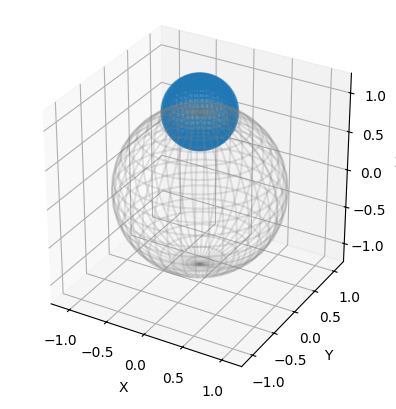

In [26]:
import itertools

n_meridians = 40
n_circles_latitude = 20

us = gs.linspace(0.0, 2 * gs.pi, n_meridians + 1)
vs = gs.linspace(0.0, gs.pi, n_circles_latitude + 1)

sphere_x = gs.array([center[0] + radius * gs.cos(u) * gs.sin(v) for u, v in itertools.product(us, vs)])
sphere_y = gs.array([center[1] + radius * gs.sin(u) * gs.sin(v) for u, v in itertools.product(us, vs)])
sphere_z = gs.array([center[2] + radius * gs.cos(v) for u, v in itertools.product(us, vs)])

ax = visualization.plot(center, space="S2")
ax.scatter(sphere_x, sphere_y, sphere_z, color="C0", alpha=0.4)

# sphere_y = center[1] + radius * gs.sin(u) * gs.sin(v)
# sphere_z = center[2] + radius * gs.cos(v)

#projected_sphere_points = space.projection(sphere_point)
#projected_sphere_points.shape

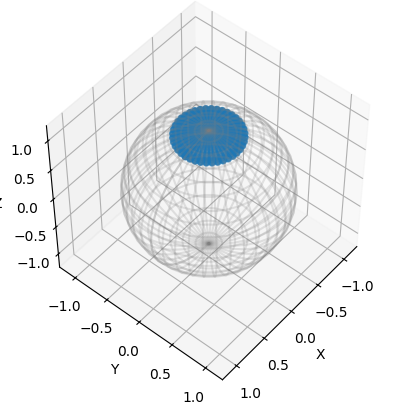

In [37]:
sphere_points = gs.vstack([sphere_x, sphere_y, sphere_z]).T
projected_points = space.projection(sphere_points)

ax = visualization.plot(center, space="S2")
ax.view_init(elev=50, azim = 40)
ax.scatter(projected_points[:, 0], projected_points[:, 1], projected_points[:, 2], color="C0", alpha=0.4)

(-1.2, 1.2, -1.2, 1.2, -1.2, 1.2)

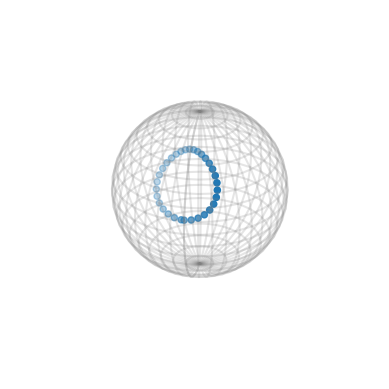

In [59]:

# Riemannian Gaussian noise, aka, Geodesic noise

us = gs.arange(0, 2*gs.pi, step = 0.2)

radius = 0.4
center = gs.array([1., 0.])
points_on_circle = [gs.array([radius*gs.cos(u) + center[0], radius*gs.sin(u)] + center[1]) for u in us]
points_on_circle = gs.array(points_on_circle)

points_extrinsic = space.intrinsic_to_extrinsic_coords(points_on_circle)

ax = visualization.plot(points_extrinsic, space="S2")
ax.view_init(azim=10)
ax.grid(False)
ax.axis("off")

## 3. Box plots of averaged results